Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB
None

First 5 Rows of Dataset:
+---+------------+--------+-----+-------------------+------------------------+---------------+-----------------+-------------+
|   | CustomerID | Gender | Age | Annual Income ($) | Spending Score (1-100) |  Profession   | Work Experience | Family Size |
+---+-----------

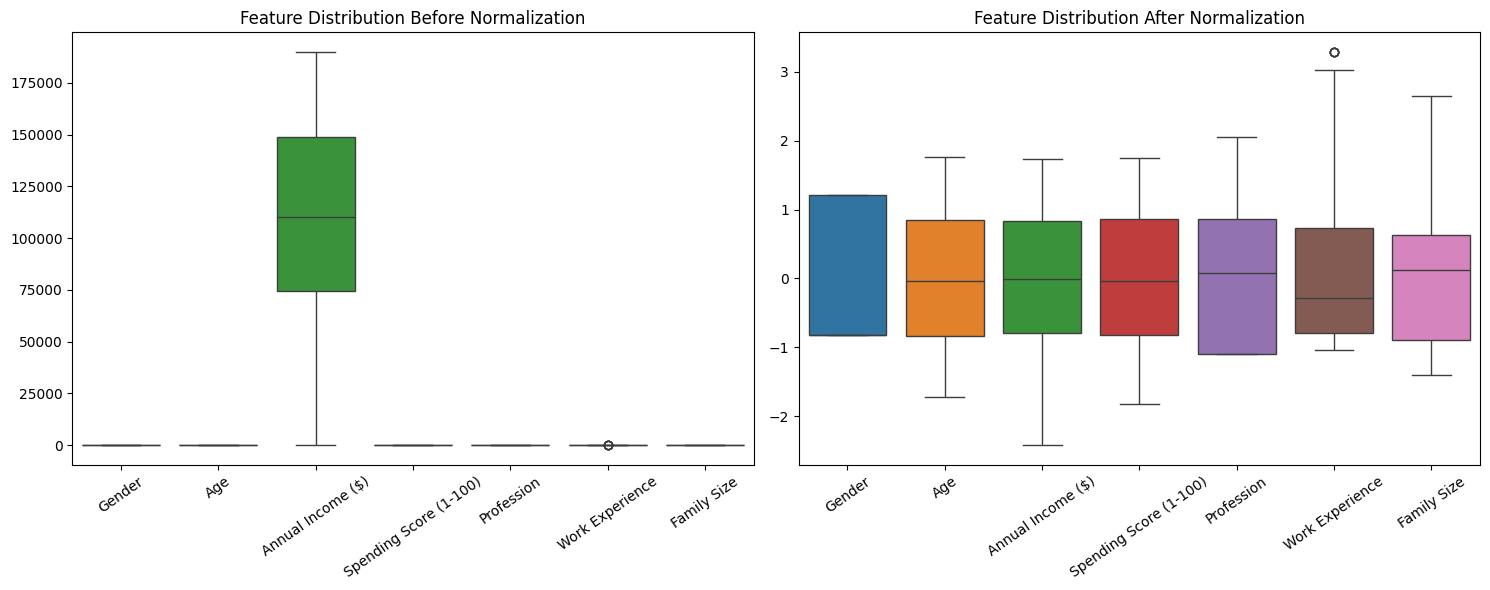

Cleaned dataset saved as 'cleaned_Customers_dataset.csv'.
Number of Outliers: 5
0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 1995, dtype: bool


In [1]:
# Import necessary libraries
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
dataset = pd.read_csv('Customers.csv') 

# Show dataset information and first 5 rows
print("Dataset Information:")
print(dataset.info())
print("\nFirst 5 Rows of Dataset:")
print(tabulate(dataset.head(), headers='keys', tablefmt='pretty'))
# Fill missing values with the most frequent value in each column
dataset = dataset.apply(lambda x: x.fillna(x.mode()[0]) if x.isna().sum() > 0 else x)
print("Missing values handled.")

# Drop 'CustomerID' 
if 'CustomerID' in dataset.columns:
    dataset = dataset.drop('CustomerID', axis=1)
print("customerid id is removed")

label_encoders = {}

# Convert categorical columns to numerical values
categorical_columns = dataset.select_dtypes(include='object').columns
if categorical_columns.empty:
    print("No categorical columns found for encoding.")
else:
    for column in categorical_columns:
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        label_encoders[column] = le  # Store encoder to access class mappings later
        print("Encoding column:", column)

        # Generate and print the mapping in the desired format
        mapping = {idx: category for idx, category in enumerate(le.classes_)}
        mapping_output = ', '.join([f"{idx}: {category}" for idx, category in mapping.items()])
        print(f"\nMapping for column '{column}':")
        print(mapping_output)

print("Categorical data encoded.")
print("\nFirst 5 Rows of Dataset after Encoding:")
print(tabulate(dataset.head(), headers='keys', tablefmt='grid'))
# Normalize the data
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Plotting before and after normalization side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot data distribution before normalization
sns.boxplot(data=dataset, ax=axes[0])
axes[0].set_title("Feature Distribution Before Normalization")
for label in axes[0].get_xticklabels():
    label.set_rotation(35)


# Plot data distribution after normalization
sns.boxplot(data=normalized_data, ax=axes[1])
axes[1].set_title("Feature Distribution After Normalization")
for label in axes[1].get_xticklabels():
    label.set_rotation(35)


plt.tight_layout()
plt.show()

# Save the cleaned, normalized dataset
cleaned_data_afterNormalization = normalized_data.copy()  # Save a copy for later use


cleaned_data_afterNormalization.to_csv('cleaned_Customers_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_Customers_dataset.csv'.")

def remove_outliers_iqr(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
    outlier_data = data[outliers]
    print(f"Number of Outliers: {outliers.sum()}")
    # Filter out outliers
    return data[~outliers]

# Apply the IQR outlier removal to normalized_data
cleaned_data_ForKmeans_and_Gmm = remove_outliers_iqr(cleaned_data_afterNormalization)
z_scores = np.abs(stats.zscore(cleaned_data_ForKmeans_and_Gmm))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
print(outliers)

In [2]:
#visualizing the dataset

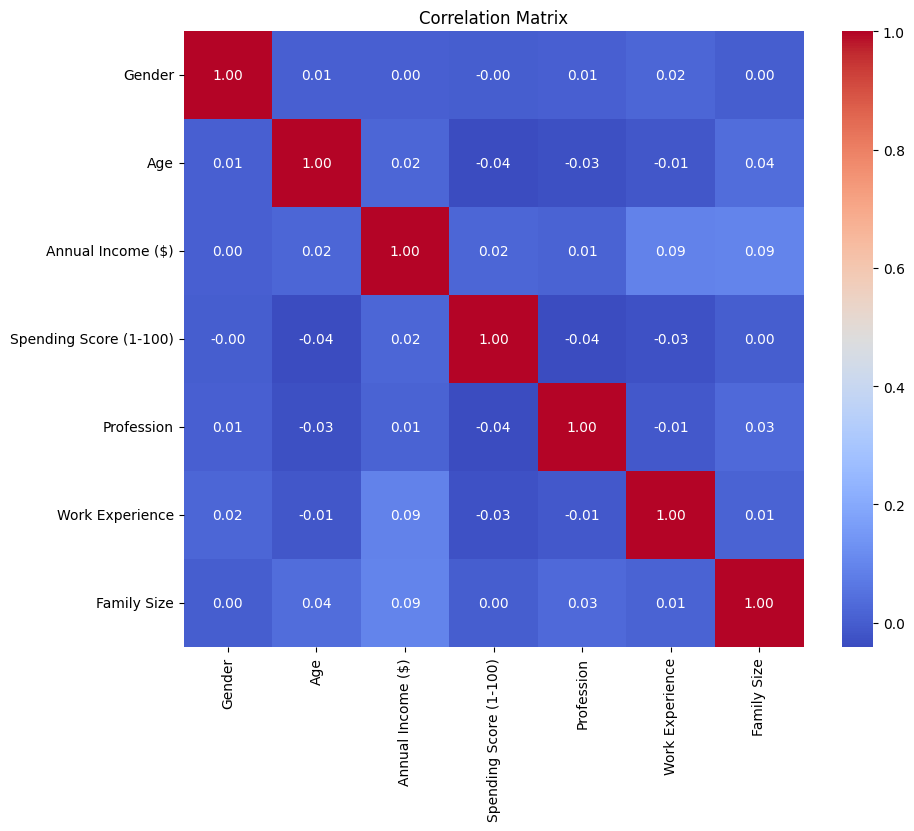

In [3]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_data_afterNormalization.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

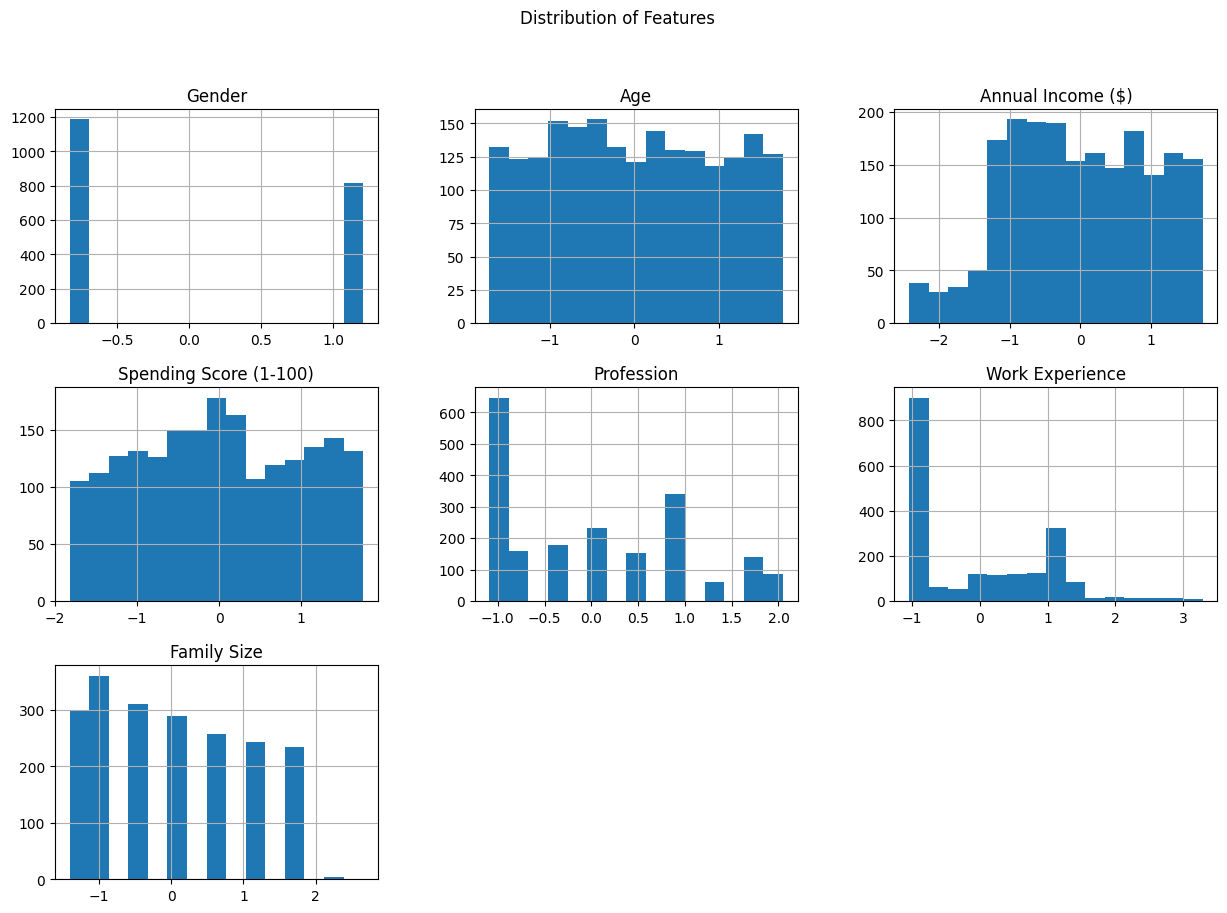

In [4]:
# Plot histograms for each column
cleaned_data_afterNormalization.hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Features')
plt.show()

In [5]:
#k means without outliers removal

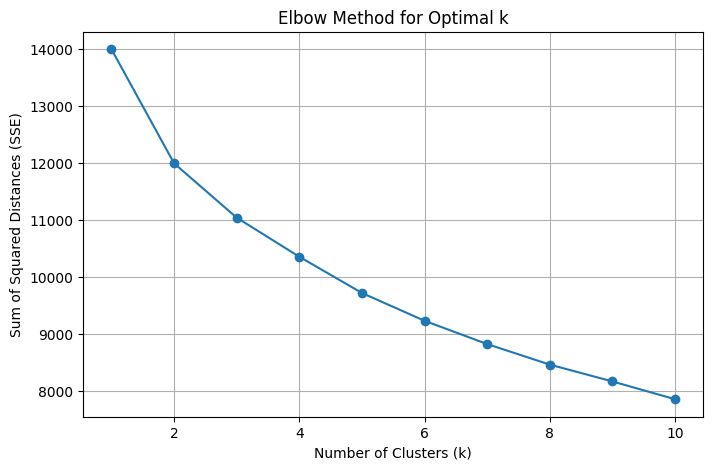

[13999.999999999985, 11998.950066741061, 11045.765963230177, 10360.515024584194, 9725.14427025249, 9237.297025405705, 8829.235380689892, 8468.947100811562, 8173.720315234579, 7862.204403549025]


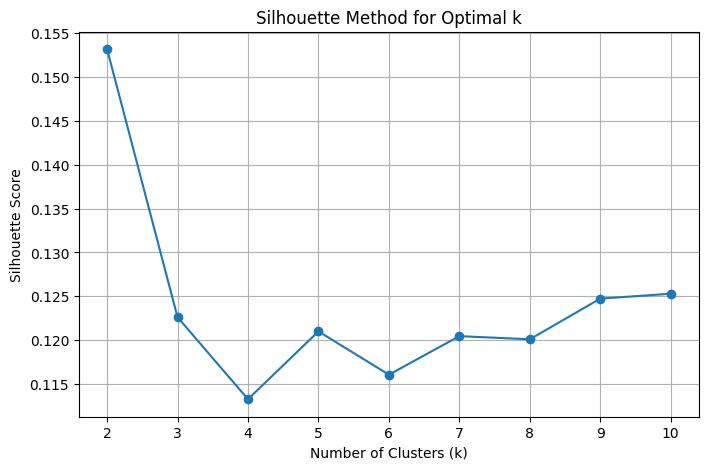

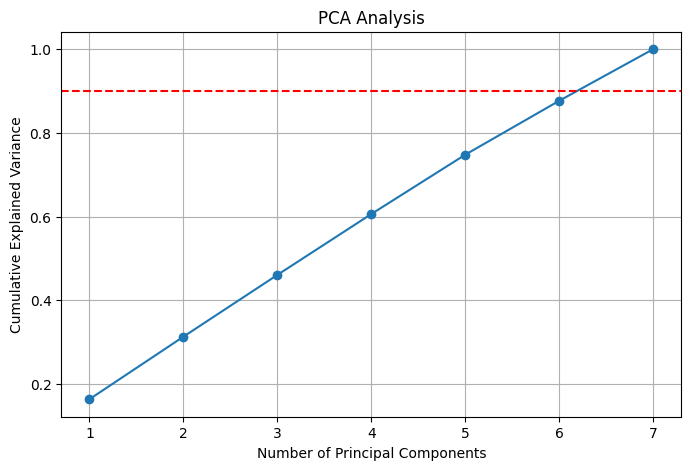

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np

# Elbow Method to determine optimal K
sse = []
k_values = range(1, 11)  # Test k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)  # Added n_init
    kmeans.fit(cleaned_data_afterNormalization)
    sse.append(kmeans.inertia_)  

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid()  # Added grid for better readability
plt.show()

print(sse)

# Silhouette Score analysis
silhouette_scores = []

for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)  # Added n_init
    labels = kmeans.fit_predict(cleaned_data_afterNormalization)
    silhouette_scores.append(silhouette_score(cleaned_data_afterNormalization, labels))

# Plot Silhouette Score vs. number of clusters (k)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid()  # Added grid for better readability
plt.show()

# PCA Analysis
pca = PCA().fit(cleaned_data_afterNormalization)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% variance line for reference
plt.grid()  # Added grid for better readability
plt.show()


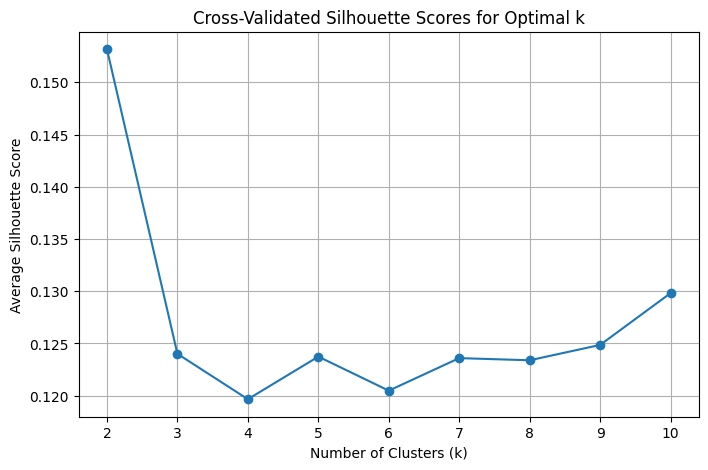

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Assuming cleaned_data_afterNormalization is a DataFrame
# Number of clusters to evaluate
k_values = range(2, 11)
n_splits = 5  # Number of folds for cross-validation

# Prepare KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store silhouette scores
cross_val_silhouette_scores = {k: [] for k in k_values}

# Cross-validated silhouette score calculation
for k in k_values:
    for train_index, test_index in kf.split(cleaned_data_afterNormalization):
        # Use .iloc to access the DataFrame rows by index
        X_train = cleaned_data_afterNormalization.iloc[train_index]
        X_test = cleaned_data_afterNormalization.iloc[test_index]

        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = kmeans.fit_predict(X_train)
        score = silhouette_score(X_train, labels)
        cross_val_silhouette_scores[k].append(score)

# Calculate average silhouette scores
avg_silhouette_scores = [np.mean(cross_val_silhouette_scores[k]) for k in k_values]

# Plotting average silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Cross-Validated Silhouette Scores for Optimal k')
plt.grid()
plt.show()


K = 2, PCA = 5:
  Silhouette Score: 0.137
  Calinski-Harabasz Score: 322.580
  Davies-Bouldin Score: 2.417

K = 2, PCA = 6:
  Silhouette Score: 0.122
  Calinski-Harabasz Score: 285.397
  Davies-Bouldin Score: 2.582

K = 2, PCA = 7:
  Silhouette Score: 0.153
  Calinski-Harabasz Score: 333.204
  Davies-Bouldin Score: 2.354

K = 3, PCA = 5:
  Silhouette Score: 0.136
  Calinski-Harabasz Score: 316.087
  Davies-Bouldin Score: 2.005

K = 3, PCA = 6:
  Silhouette Score: 0.114
  Calinski-Harabasz Score: 257.897
  Davies-Bouldin Score: 2.260

K = 3, PCA = 7:
  Silhouette Score: 0.131
  Calinski-Harabasz Score: 266.754
  Davies-Bouldin Score: 2.301

K = 4, PCA = 5:
  Silhouette Score: 0.168
  Calinski-Harabasz Score: 339.365
  Davies-Bouldin Score: 1.813

K = 4, PCA = 6:
  Silhouette Score: 0.118
  Calinski-Harabasz Score: 245.676
  Davies-Bouldin Score: 2.006

K = 4, PCA = 7:
  Silhouette Score: 0.113
  Calinski-Harabasz Score: 233.723
  Davies-Bouldin Score: 2.110

K = 5, PCA = 5:
  Silhouette

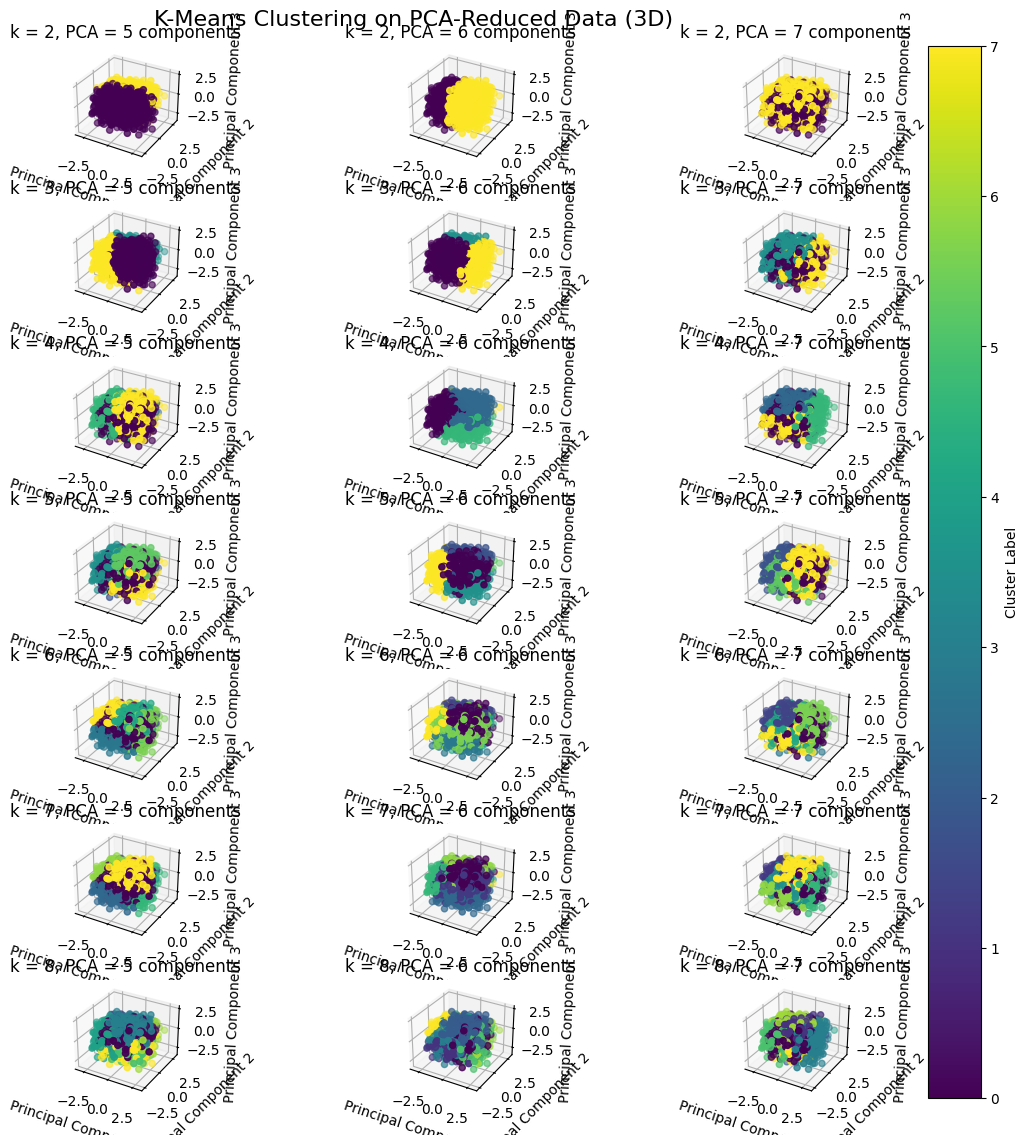

Best Parameters based on Performance Metrics:
Best Silhouette Score: K = 6, PCA Components = 5
Best Calinski-Harabasz Score: K = 4, PCA Components = 5
Best Davies-Bouldin Score: K = 7, PCA Components = 5


In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing the 3D toolkit

# Define the range of k and n_components to iterate over
k_values = [2, 3, 4, 5, 6, 7, 8]
pca_components = [5, 6, 7]  # Ensure components start from 3 for 3D plotting

# Initialize variables to track the best scores and corresponding parameters
best_silhouette = -1
best_calinski_harabasz = -1
best_davies_bouldin = float('inf')
best_params = {
    'silhouette': None,
    'calinski_harabasz': None,
    'davies_bouldin': None
}

# Create a figure for 3D plots
fig = plt.figure(figsize=(15, 12))
fig.suptitle('K-Means Clustering on PCA-Reduced Data (3D)', fontsize=16, y=0.92)

for i, k in enumerate(k_values):
    for j, n_components in enumerate(pca_components):
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(cleaned_data_afterNormalization)
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_data)
        
        # Check if n_components is at least 3 for 3D plotting
        if n_components >= 3:
            # Create a 3D plot
            ax = fig.add_subplot(len(k_values), len(pca_components), i * len(pca_components) + j + 1, projection='3d')
            
            # Plot the clustering results in 3D
            scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', marker='o')
            ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='X')
            
            ax.set_title(f'k = {k}, PCA = {n_components} components')
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
        
            # Compute performance metrics
            silhouette = silhouette_score(reduced_data, labels)
            calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
            davies_bouldin = davies_bouldin_score(reduced_data, labels)
            
            # Print performance metrics
            print(f"K = {k}, PCA = {n_components}:")
            print(f"  Silhouette Score: {silhouette:.3f}")
            print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
            print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}\n")

            # Update best scores and parameters
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params['silhouette'] = (k, n_components)
            if calinski_harabasz > best_calinski_harabasz:
                best_calinski_harabasz = calinski_harabasz
                best_params['calinski_harabasz'] = (k, n_components)
            if davies_bouldin < best_davies_bouldin:
                best_davies_bouldin = davies_bouldin
                best_params['davies_bouldin'] = (k, n_components)

        else:
            # Skip or handle cases where n_components < 3 (could also plot in 2D if desired)
            print(f"Skipping plot for k = {k} with PCA = {n_components} components (less than 3 components).")
            continue

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.colorbar(scatter, ax=fig.axes, label='Cluster Label', orientation='vertical')
plt.show()

# Summary of best parameters for each metric
print("Best Parameters based on Performance Metrics:")
print(f"Best Silhouette Score: K = {best_params['silhouette'][0]}, PCA Components = {best_params['silhouette'][1]}")
print(f"Best Calinski-Harabasz Score: K = {best_params['calinski_harabasz'][0]}, PCA Components = {best_params['calinski_harabasz'][1]}")
print(f"Best Davies-Bouldin Score: K = {best_params['davies_bouldin'][0]}, PCA Components = {best_params['davies_bouldin'][1]}")


K = 4, PCA = 5:
  Silhouette Score: 0.168
  Calinski-Harabasz Score: 339.365
  Davies-Bouldin Score: 1.813

K = 6, PCA = 5:
  Silhouette Score: 0.175
  Calinski-Harabasz Score: 323.708
  Davies-Bouldin Score: 1.569

K = 7, PCA = 5:
  Silhouette Score: 0.173
  Calinski-Harabasz Score: 314.994
  Davies-Bouldin Score: 1.478



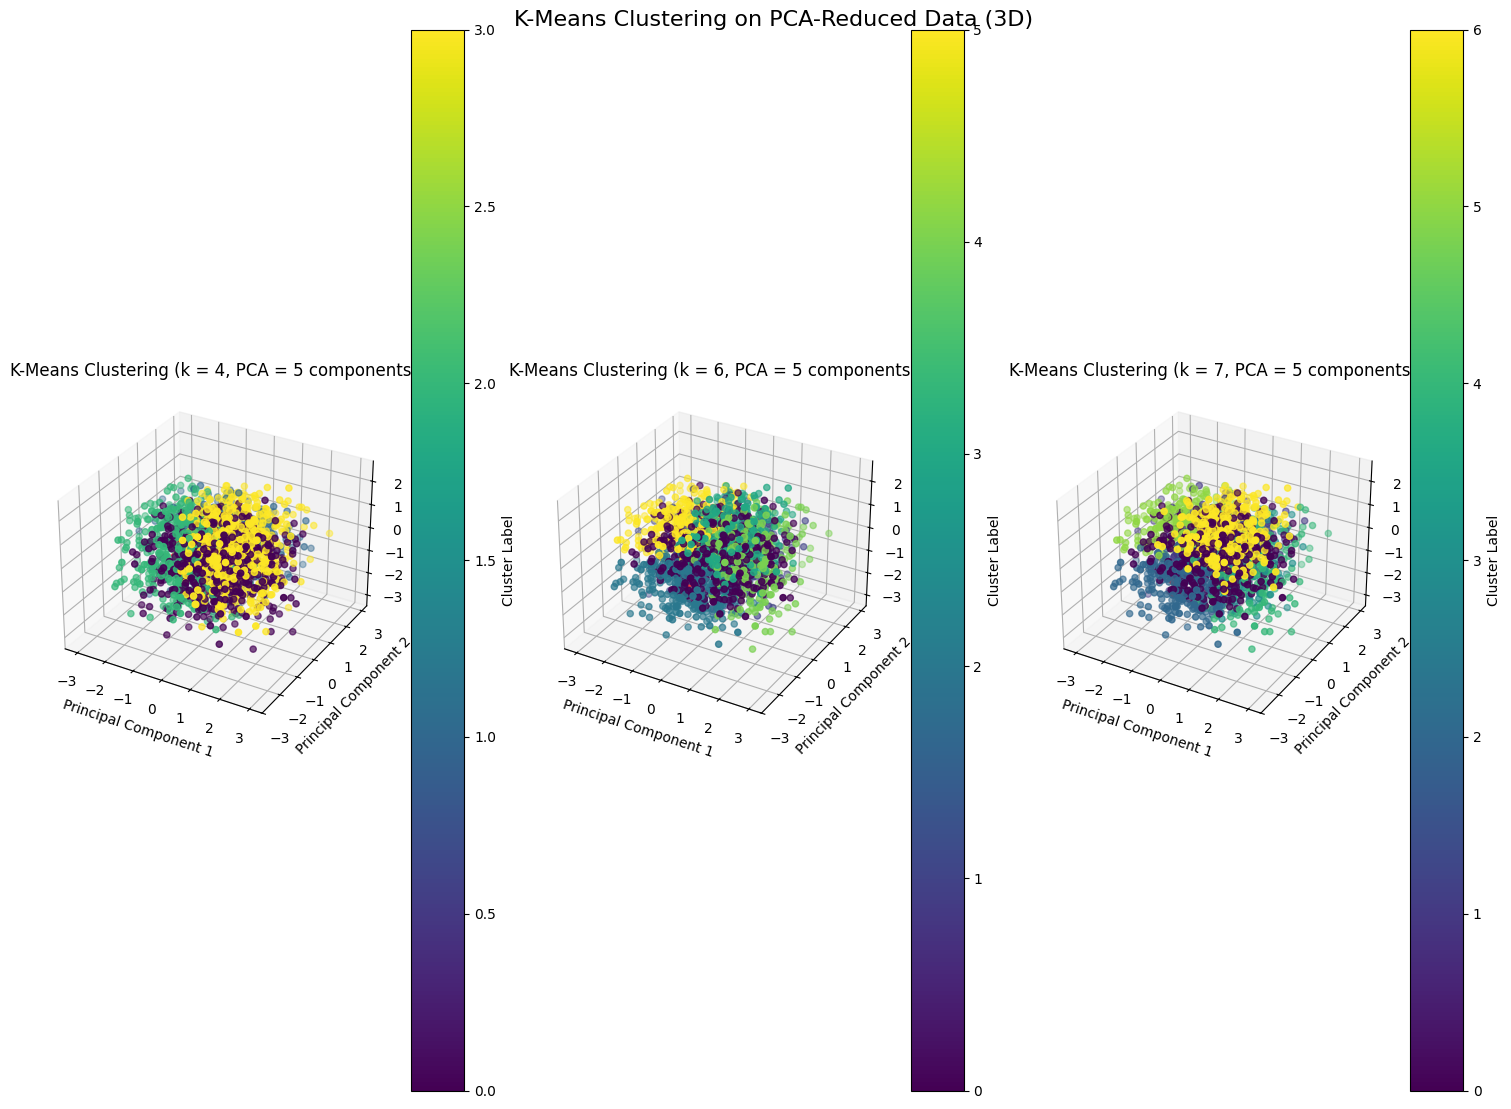

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Set specific values for k and the number of PCA components
k_values = [4, 6, 7]
n_components = 5

# Create a figure for 3D plots
fig = plt.figure(figsize=(15, 12))
fig.suptitle('K-Means Clustering on PCA-Reduced Data (3D)', fontsize=16, y=0.92)

# Iterate over the specified values of k
for k in k_values:
    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(cleaned_data_afterNormalization)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(reduced_data)  # Capture the labels here

    # Create a 3D plot for the clustering results
    ax = fig.add_subplot(1, len(k_values), k_values.index(k) + 1, projection='3d')
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', marker='o')
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='X')
    ax.set_title(f'K-Means Clustering (k = {k}, PCA = {n_components} components)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    fig.colorbar(scatter, ax=ax, label='Cluster Label')

    # Compute performance metrics
    silhouette = silhouette_score(reduced_data, labels)
    calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
    davies_bouldin = davies_bouldin_score(reduced_data, labels)

    print(f"K = {k}, PCA = {n_components}:")
    print(f"  Silhouette Score: {silhouette:.3f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}\n")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


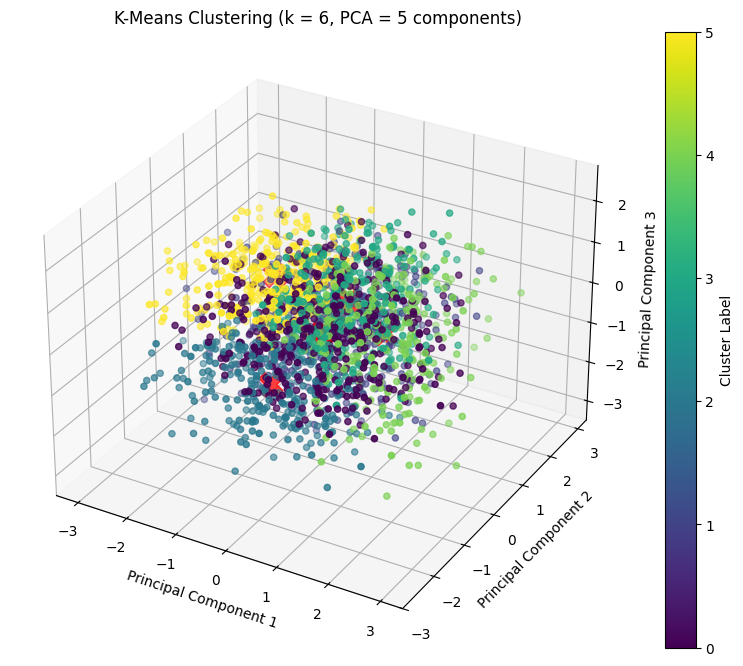

K = 6, PCA = 5:
  Silhouette Score: 0.175
  Calinski-Harabasz Score: 323.708
  Davies-Bouldin Score: 1.569


In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Set specific values for k and n_components
k = 6
n_components = 5

# Apply PCA with 3 components
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(cleaned_data_afterNormalization)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)  # Capture the labels here

# Plot the clustering results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', marker='o')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='X')
ax.set_title(f'K-Means Clustering (k = {k}, PCA = {n_components} components)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, label='Cluster Label')
plt.show()

# Compute performance metrics
silhouette = silhouette_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
davies_bouldin = davies_bouldin_score(reduced_data, labels)

print(f"K = {k}, PCA = {n_components}:")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")


In [11]:
!pip3 install plotly



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Set specific values for k and n_components
k = 6
n_components = 5

# Apply PCA with 5 components
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(cleaned_data_afterNormalization)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)  # Capture the labels here
centroids = kmeans.cluster_centers_

# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Add points for each cluster
fig.add_trace(go.Scatter3d(
    x=reduced_data[:, 0], 
    y=reduced_data[:, 1], 
    z=reduced_data[:, 2], 
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # Color by cluster
        colorscale='Viridis',
        opacity=0.7
    ),
    name='Data Points'
))

# Add centroids
fig.add_trace(go.Scatter3d(
    x=centroids[:, 0], 
    y=centroids[:, 1], 
    z=centroids[:, 2], 
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='x',
        opacity=0.9
    ),
    name='Centroids'
))

# Set titles and axis labels
fig.update_layout(
    title=f'K-Means Clustering (k = {k}, PCA = {n_components} components)',
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    )
)

fig.show()

# Compute performance metrics
silhouette = silhouette_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
davies_bouldin = davies_bouldin_score(reduced_data, labels)

print(f"K = {k}, PCA = {n_components}:")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")


K = 6, PCA = 5:
  Silhouette Score: 0.175
  Calinski-Harabasz Score: 323.708
  Davies-Bouldin Score: 1.569


In [13]:
#dbscan

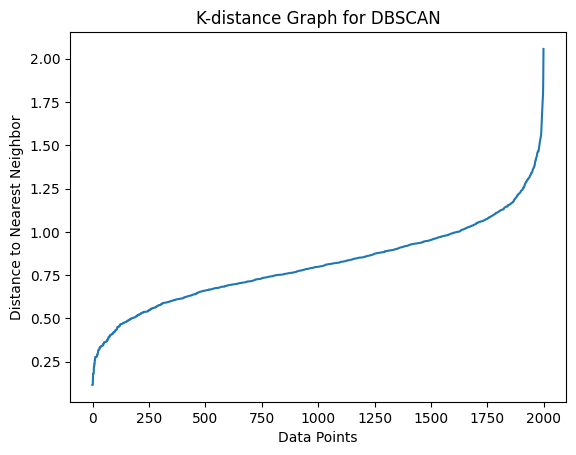

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Determine eps using Nearest Neighbors =distance to the nearest neighbor starts to increase sharply
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cleaned_data_afterNormalization)
distances, indices = nbrs.kneighbors(cleaned_data_afterNormalization)
distances = np.sort(distances[:, 1], axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Distance to Nearest Neighbor')
plt.title('K-distance Graph for DBSCAN')
plt.show()

In [15]:
from sklearn.cluster import DBSCAN
import pandas as pd
from tabulate import tabulate

# Define your parameter values
min_samples_values = [7,8, 9, 10, 11]  # Start around 8-10 based on dimensionality
eps_values = [1.25,1.5, 1.75, 2.0]  # Adjust these based on K-distance graph
cleaned_data_dbscan=cleaned_data_afterNormalization.copy()

# Assume cleaned_data is already defined
results = []  # To store results for each combination

# Variable to track the best eps and min_samples with the least -1 count
best_eps = None
best_min_samples = None
min_noise_count = float('inf')  # Start with infinity for comparison

# Loop through all combinations of eps and min_samples
for min_samples in min_samples_values:
    for eps in eps_values:
        # Fit the DBSCAN model
        db_scanclustermodel = DBSCAN(eps=eps, min_samples=min_samples).fit(cleaned_data_afterNormalization)

        # Add the cluster labels to cleaned_data
        cleaned_data_dbscan.loc[:, 'cluster'] = db_scanclustermodel.labels_

        # Count and print the number of clusters, including noise (-1)
        cluster_counts = cleaned_data_dbscan['cluster'].value_counts()
        noise_count = cluster_counts.get(-1, 0)  # Get count of noise points, default to 0

        print(f"DBSCAN with eps={eps} and min_samples={min_samples}")
        print(tabulate(cleaned_data_dbscan.head(), headers='keys', tablefmt='grid'))
        print(f"Noise points (-1) count: {noise_count}")
        
        # Check if this is the least noise count observed so far
        if noise_count < min_noise_count:
            min_noise_count = noise_count
            best_eps = eps
            best_min_samples = min_samples
        
        # Append the result for further analysis if needed
        results.append((eps, min_samples, noise_count))

# Print the best parameters with the least -1 cluster count
print(f"\nBest eps: {best_eps}, Best min_samples: {best_min_samples} with noise count: {min_noise_count}")



DBSCAN with eps=1.25 and min_samples=7
+----+-----------+-----------+---------------------+--------------------------+--------------+-------------------+---------------+-----------+
|    |    Gender |       Age |   Annual Income ($) |   Spending Score (1-100) |   Profession |   Work Experience |   Family Size |   cluster |
+====+===========+===========+=====================+==========================+==============+===================+===============+===========+
|  0 |  1.20706  | -1.05409  |           -2.0935   |                -0.428339 |    0.870495  |         -0.791207 |      0.117497 |         0 |
+----+-----------+-----------+---------------------+--------------------------+--------------+-------------------+---------------+-----------+
|  1 |  1.20706  | -0.983723 |           -1.65613  |                 1.07555  |   -0.30638   |         -0.281162 |     -0.390051 |         0 |
+----+-----------+-----------+---------------------+--------------------------+--------------+---------


Silhouette Score: 0.17442435336154652
Davies-Bouldin Index: 1.7015086151224186


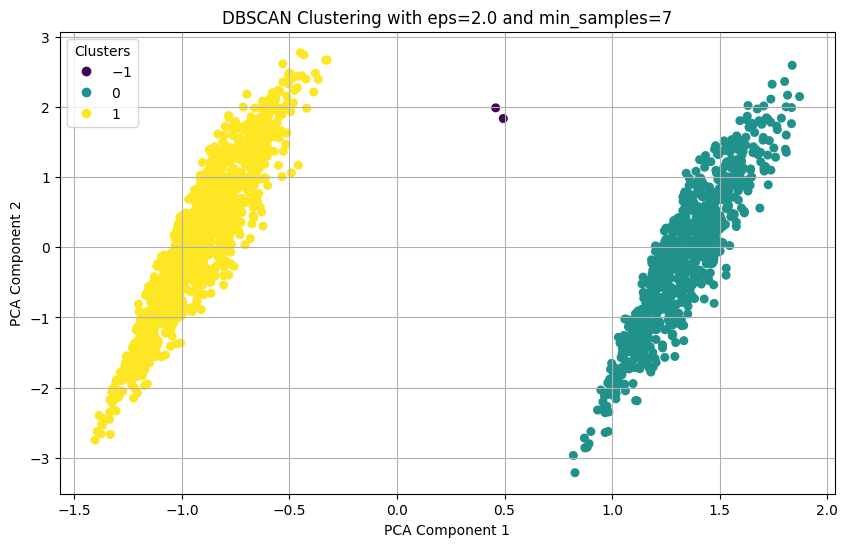

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the best parameters obtained from previous runs
best_eps = 2.0
best_min_samples = 7

# Fit the DBSCAN model with the best parameters
db_scanclustermodel = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(cleaned_data_dbscan)

# Add the cluster labels to cleaned_data
cleaned_data_dbscan.loc[:, 'cluster'] = db_scanclustermodel.labels_
# Calculate performance metrics
if len(set(db_scanclustermodel.labels_)) > 1:  # Ensure there is more than one cluster
    silhouette_avg = silhouette_score(cleaned_data_dbscan, db_scanclustermodel.labels_)
    db_index = davies_bouldin_score(cleaned_data_dbscan, db_scanclustermodel.labels_)
else:
    silhouette_avg = -1  # If there's only one cluster or all are noise
    db_index = float('inf')  # Arbitrarily high since there's no valid clustering

# Print the metrics
print(f"\nSilhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {db_index}")

# PCA for 2D visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cleaned_data_dbscan)

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cleaned_data_dbscan['cluster'], cmap='viridis', marker='o', s=30)
plt.title(f"DBSCAN Clustering with eps={best_eps} and min_samples={best_min_samples}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Create a legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")
# Show the plot
plt.grid()
plt.show()


In [17]:
#GMM

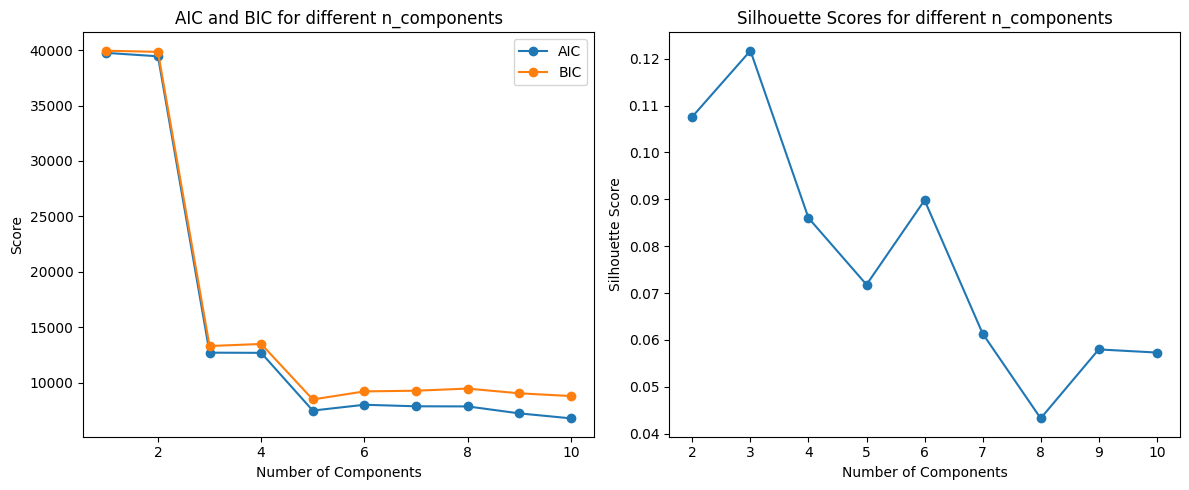

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Range of components to try
n_components_range = range(1, 11)
aic_values = []
bic_values = []
silhouette_scores = []
cleaned_data_gmm=cleaned_data_afterNormalization.copy()

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(cleaned_data_gmm)
    
    # Append AIC and BIC values
    aic_values.append(gmm.aic(cleaned_data_gmm))
    bic_values.append(gmm.bic(cleaned_data_gmm))
    
    # If there are more than one cluster, compute silhouette score
    if n_components > 1:
        cluster_labels = gmm.predict(cleaned_data_gmm)
        silhouette_avg = silhouette_score(cleaned_data_gmm, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)  # Not defined for a single cluster

# Plotting AIC and BIC-- lowest points on the AIC and BIC curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_values, marker='o', label='AIC')
plt.plot(n_components_range, bic_values, marker='o', label='BIC')
plt.title('AIC and BIC for different n_components')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

# Plotting silhouette scores--highest silhouette score indicates the best-defined clusters
plt.subplot(1, 2, 2)
plt.plot(n_components_range[1:], silhouette_scores[1:], marker='o')
plt.title('Silhouette Scores for different n_components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



Cluster counts for GMM with 7 components:
0    245
1    318
2    217
3    236
4    316
5    337
6    331
Name: count, dtype: int64

Cluster counts for GMM with 5 components:
0    282
1    411
2    328
3    420
4    559
Name: count, dtype: int64


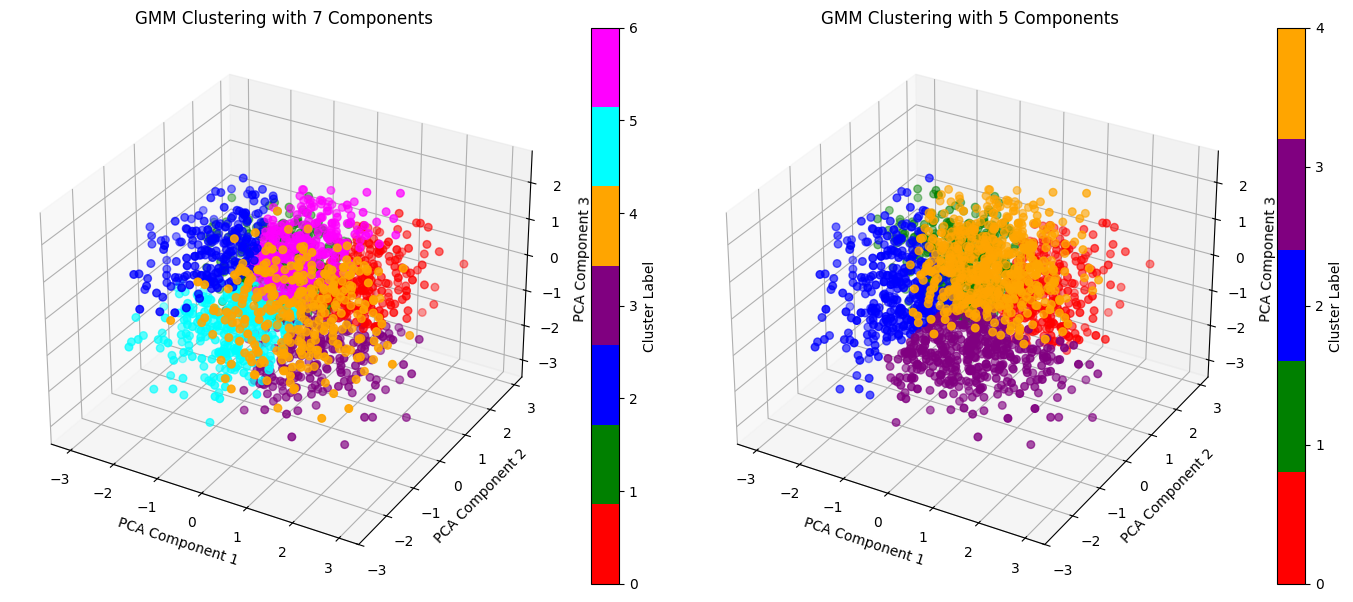

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting

# Assuming cleaned_data_gmm is already defined and contains the normalized data

# Reduce the dimensions of the data to 3D using PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(cleaned_data_gmm)

# Fit GMM with 7 components
gmm_7 = GaussianMixture(n_components=7, covariance_type='full', random_state=42)
gmm_7.fit(reduced_data)
labels_7 = gmm_7.predict(reduced_data)

# Fit GMM with 5 components
gmm_5 = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_5.fit(reduced_data)
labels_5 = gmm_5.predict(reduced_data)

# Count points in each cluster for 7 components
cluster_counts_7 = pd.Series(labels_7).value_counts().sort_index()
print("\nCluster counts for GMM with 7 components:")
print(cluster_counts_7)

# Count points in each cluster for 5 components
cluster_counts_5 = pd.Series(labels_5).value_counts().sort_index()
print("\nCluster counts for GMM with 5 components:")
print(cluster_counts_5)

# Define custom colors for clusters
colors_7 = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta']
colors_5 = ['red', 'green', 'blue', 'purple', 'orange']

# Visualize results for 7 components in 3D
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], 
                     c=labels_7, cmap=ListedColormap(colors_7), marker='o', s=30)
ax.set_title('GMM Clustering with 7 Components')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter, ticks=range(len(colors_7)), label='Cluster Label')
ax.grid()

# Visualize results for 5 components in 3D
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], 
                     c=labels_5, cmap=ListedColormap(colors_5), marker='o', s=30)
ax.set_title('GMM Clustering with 5 Components')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter, ticks=range(len(colors_5)), label='Cluster Label')
ax.grid()

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Function to calculate performance metrics
def calculate_performance_metrics(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette_avg, calinski_harabasz, davies_bouldin


# Calculate performance metrics for GMM with 7 components
metrics_7 = calculate_performance_metrics(reduced_data, labels_7)
print(f"\nPerformance Metrics for GMM with 7 Components:")
print(f"Silhouette Score: {metrics_7[0]}")
print(f"Calinski-Harabasz Index: {metrics_7[1]}")
print(f"Davies-Bouldin Index: {metrics_7[2]}")

# Calculate performance metrics for GMM with 5 components
metrics_5 = calculate_performance_metrics(reduced_data, labels_5)
print(f"\nPerformance Metrics for GMM with 5 Components:")
print(f"Silhouette Score: {metrics_5[0]}")
print(f"Calinski-Harabasz Index: {metrics_5[1]}")
print(f"Davies-Bouldin Index: {metrics_5[2]}")


Performance Metrics for GMM with 7 Components:
Silhouette Score: 0.21913163263059302
Calinski-Harabasz Index: 591.6762279327465
Davies-Bouldin Index: 1.163339286801102

Performance Metrics for GMM with 5 Components:
Silhouette Score: 0.23306170919575347
Calinski-Harabasz Index: 641.9443304185417
Davies-Bouldin Index: 1.1551122877314501
